# ASTR 598 Astrostatistics
## HW2 Part 2
## Hayden Smotherman, Chris Suberlack, Winnie Wang
## To run this Notebook:

Data files have not been uploaded to github because of size. Group 2 is analyzing NSC data, which should all be in group2/HW_2/. The NSC files are generated by uploading the HW2_DL_NCS.ipynb notebook to datalab servers, running the notebook, then downloading the two .csv files that are output.

In [1]:
# Imports 
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
from astropy.table import vstack
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import os
import numpy as np
from astropy.io import fits
import pandas as pd
from scipy.stats import binned_statistic_2d as bs2d 
from scipy.stats import binned_statistic as bs1d
import seaborn as sns

In [2]:
# Load the NSC data ... takes 2 mins 
# Group two is only using NSC data
table_neg = Table.read('NSC_stripe82_Dec_negative.csv')
table_pos = Table.read('NSC_stripe82_Dec_positive.csv')

# Stack the two tables vertically 
# ( rows over rows,  since the columns ARE IDENTICAL )
# this is even faster than any other merge, etc. 
nsc = vstack([table_neg, table_pos])

## Part (a)

In [ ]:
# Generate the magnitude mask used in the Hess diagram data analysis
def Hess_r_v_gminusi(nsc,total_mask):
    constant = 3 # This is a fudge parameter in determining number of bins
    nObjects = np.sum(total_mask)
    num_bins = int(constant * nObjects ** (1.0 / 4.0))

    # Now calculate the binned proper motions
    proper_motion = np.sqrt(nsc['pmra']**2+nsc['pmdec']**2)
    total_mask = proper_motion<100*total_mask
    Binned_PM = bs2d(nsc['ra'][total_mask],nsc['rmag'][total_mask],proper_motion[total_mask], bins = num_bins)


    #cmin = min(np.log10(Binned_PM.statistic.T[Binned_PM.statistic.T >  0]))
    #cmax = max(np.log10(Binned_PM.statistic.T[Binned_PM.statistic.T >  0]))

    # Define custom colormaps: Set pixels with no sources to white
    cmap = plt.cm.viridis
    cmap.set_bad('w', 1.)

    plt.figure(figsize=[8,8])
    plt.imshow(Binned_PM.statistic.T, origin='lower',
                   extent=[Binned_PM.x_edge[0], Binned_PM.x_edge[-1], Binned_PM.y_edge[0], Binned_PM.y_edge[-1]],
                   aspect='auto', interpolation='nearest', cmap=cmap)

    cb = plt.colorbar(orientation='horizontal')
    cb.set_label(r'Proper Motion [mas/yr]',fontsize=16)
    plt.clim(0, 30) # This was set by hand to draw out as much detail as possible

    plt.xlabel(r'RA [degree]',fontsize=16)
    plt.ylabel(r'r',fontsize=16)
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()

# Make the color masks
r_mask = (nsc['rmag']>20.5) & (nsc['rmag']<21)
gminusi_mask = ((nsc['gmag']-nsc['imag']) > 0.3) & ((nsc['gmag']-nsc['imag']) < 0.4)
mag_mask = r_mask * gminusi_mask

# Mask everything but stars
star_mask = (nsc['class_star']>0.5)

# Make the RA Masks
RA_mask_25to40 = (nsc['ra'] > 25) & (nsc['ra'] < 40)
RA_mask_0to15 = (nsc['ra'] > 0) & (nsc['ra'] < 15)

# Make the net masks
mask_25to40 = mag_mask * RA_mask_25to40 * star_mask
mask_0to15 = mag_mask * RA_mask_0to15 * star_mask

# Make the Hess diagram for 25 < RA < 40
Hess_r_v_gminusi(nsc,mask_25to40)
plt.title(r'Proper Motion for $25^\circ < \mathrm{RA} < 40^\circ$',fontsize=20)
plt.savefig('pm_Hess_Diagram_RA25to40') # Save the figure

# Make the Hess diagram for 0 < RA < 15
Hess_r_v_gminusi(nsc,mask_0to15)
plt.title(r'Proper Motion for $0^\circ < \mathrm{RA} < 15^\circ$',fontsize=20)
plt.savefig('pm_Hess_Diagram_RA0to15') # Save the figure


The Hess diagram at high-RA values seems to show some bimodality in the proper motion spacial distribution. The split occurs nearly exactly on the border of the Sagitarius stream. We don't see any such bimodality in the low-RA region.

In [ ]:
def ProperMotionHist(nsc,mask_noRAcuts,normed='True'):
    # This function makes a histogram of RA Proper motions for two different RA cuts
    
    # Calculate the total Proper Motion
    proper_motion = np.sqrt(nsc['pmra']**2+nsc['pmdec']**2)
    mask_noRAcuts = proper_motion<100*mask_noRAcuts
    
    # Make two masks that have the RA cuts included
    RA_mask_0to15 = (nsc['ra'] > 0) & (nsc['ra'] < 15)
    RA_mask_25to40 = (nsc['ra'] > 25) & (nsc['ra'] < 40)
    mask_0to15 = mask_noRAcuts * RA_mask_0to15
    mask_25to40 = mask_noRAcuts * RA_mask_25to40
    
    #Plot the two distributions with different RA cuts
    plt.figure(figsize=[12,8])
    plt.hist(proper_motion[mask_0to15],alpha=0.5,bins=50,normed=normed,linewidth=3,color='r')
    plt.hist(proper_motion[mask_25to40],alpha=0.5,bins=50,normed=normed,linewidth=3,color='b')

    plt.legend([r'$0^\circ < \mathrm{RA} < 15^\circ$',r'$25^\circ < \mathrm{RA} < 40^\circ$'],fontsize=16)
    plt.title('Distribution of Proper Motions for different RA cuts',fontsize=20)
    plt.xlabel('Proper Motion Number [mas/yr]',fontsize=16)
    plt.ylabel('Normed number density',fontsize=16)
    plt.xlim([0,50])
    #plt.ylim([1,200])
    
# Make some universal cuts
r_mask = (nsc['rmag']>20.5) & (nsc['rmag']<21)
gminusi_mask = ((nsc['gmag']-nsc['imag']) > 0.3) & ((nsc['gmag']-nsc['imag']) < 0.4)
mag_mask = r_mask * gminusi_mask

# Mask everything but stars
star_mask = (nsc['class_star']>0.5)

ProperMotionHist(nsc,mag_mask*star_mask)

When normalized, there is very little difference between the high and low RA cuts of the proper motion distributions.

## Part (b)

In [ ]:
#setting up data:
result = nsc # quick alias

#make mask to find galaxies
SG = result['class_star']
mask_galaxy = result['class_star'] > 0.5
mask_star = result['class_star'] < 0.5

ra = result['ra'][mask_galaxy]
dec = result['dec'] 

pmra = result['pmra'][mask_galaxy] 
pmdec = result['pmdec'][mask_galaxy] 
pmraerr = result['pmraerr'][mask_galaxy] 
pmdecerr = result['pmdecerr'][mask_galaxy]

chi_ra = pmra / pmraerr
chi_dec = pmdec / pmdecerr

raW = np.where(ra>180, ra-360, ra)

In [ ]:
#masks to limit the data we are plotting
mask = np.abs(pmra) < 100
mask2 = np.abs(pmdec) < 100 
mask3 = np.abs(chi_ra) < 100
mask4 = np.abs(chi_dec) < 100

Histogram plots for proper motion in R.A and Dec:

In [ ]:
n_bins = 20
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True,figsize=[12,8])

# We can set the number of bins with the `bins` kwarg
axs.hist(pmra[mask], alpha=0.5, bins=n_bins, color='b', label="pm_ra")
axs.hist(pmdec[mask2], alpha=0.5, bins=n_bins, color='r',label="pm_dec")

plt.legend()
axs.set_xlabel('Proper motion',fontsize=12)
axs.set_ylabel('Counts',fontsize=12)
axs.set_title('Histogram of Proper Motion (RA, Dec)')

Histogram plots for chi^2==pm/pmerr in R.A and Dec:

In [ ]:
n_bins = 20
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True,figsize=[12,8])
n_chi_ra = len(chi_ra)
n_chi_dec = len(chi_dec)

print("Median of chi_ra: "+str(np.median(chi_ra)))
print("Median of chi_dec: "+str(np.median(chi_dec)))

axs.hist(chi_ra[mask3]/(n_chi_ra - 1), alpha=0.5, bins=n_bins, color='b', label="${\chi}^{2}$ ra")
axs.hist(chi_dec[mask4]/(n_chi_dec - 1), alpha=0.5, bins=n_bins, color='r', label="${\chi}^{2}$ dec")

plt.legend()
axs.set_xlabel('${\chi}^{2} = pm/pmerr$',fontsize=10)
axs.set_ylabel('Counts',fontsize=10)
axs.set_title("Histogram of ${\chi}^{2}$ (RA,Dec)")

Since ${\chi}^{2}$ for Dec. is far away from zero, we plotted functions of PM_ra and PM_dec vs. RA:

Plot of PM_ra vs. RA:

In [ ]:
col0 = raW
#col1 = dec 
col2 = pmra
#print(col0.size)

fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col2, bins='log', cmap=plt.cm.inferno,
               mincnt=1, extent=(-45, 45.0, -1.3, 1.3))

ax1.axis([45, -45, -1.3, 1.3])
ax1.set_xlabel('R.A.',fontsize=20)
ax1.set_ylabel('PM_ra',fontsize=20)
ax1.set_title('PM_ra vs. R.A. plot',fontsize=20)

cb = plt.colorbar(im1,label='log(N)') #color bar

Plot of PM_dec vs. RA:

In [ ]:
# median is off from zero; plotting of pm_dec vs. ra

col0 = raW
#col1 = dec 
col2 = pmdec
#print(col0.size)

fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col2, bins='log', cmap=plt.cm.inferno,
               mincnt=1, extent=(-45, 45.0, -1.3, 1.3))

ax1.axis([45, -45, -1.3, 1.3])
ax1.set_xlabel('R.A.',fontsize=20)
ax1.set_ylabel('PM_dec',fontsize=20)
ax1.set_title('PM_dec vs. R.A. plot',fontsize=20)

cb = plt.colorbar(im1,label='log(N)')#color bar

## Part (c)

"Systematic errors in HLC, NSC (and joint) proper motions can be
also be gauged using ~10,000 quasars from the catalog DR12Q.fits from
http://www.sdss.org/dr12/algorithms/boss-dr12-quasar-catalog/"

"plot the median and sigmaG vs. RA for RA and Dec proper motion 
components for quasars with 17 < r < 20 from that file (~1 deg wide 
bins in RA, but try a factor of 3 smaller and larger bins and discuss). "


In [3]:
hdu = fits.open('DR12Q.fits')
#hdu.info()
db_qso = Table(hdu[1].data)

In [ ]:
# quickly check coverage ...
%matplotlib inline
plt.scatter(db_qso['RA'], db_qso['DEC'], s=0.001)
# entire SDSS pretty much ! 

In [ ]:
%matplotlib inline
# Select only the S82 part ...
m_ra = np.abs(db_qso['DEC']) < 2
m_dec = ( db_qso['RA'] < 50 ) | (300 < db_qso['RA'])
m = m_ra * m_dec 
plt.scatter(db_qso['RA'][m], db_qso['DEC'][m], s=0.01)

In [4]:
# re-express the ra from 0-360 to +/- 180 ..
db_qso['RA_W'] = np.where(db_qso['RA']>180, db_qso['RA']-360, db_qso['RA'])
nsc['ra_W'] = np.where(nsc['ra']>180, nsc['ra']-360, nsc['ra'])

In [ ]:
# Plot again...
m = np.abs(db_qso['DEC']) < 2
plt.scatter(db_qso['RA_W'][m], db_qso['DEC'][m], s=0.01)

In [ ]:
# that's just S82 because that's what we queried for ...
plt.scatter(nsc['ra_W'], nsc['dec'], s=0.0001)

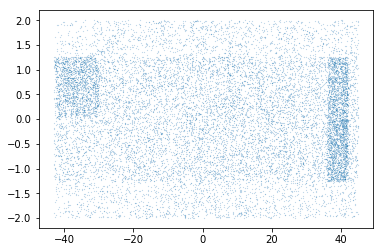

In [5]:
# Limit the DR12 QSO DB to ra limits ...

m_dec = np.abs(db_qso['DEC']) < 2
m_ra = np.abs(db_qso['RA_W']) < 50 
m = m_dec * m_ra
plt.scatter(db_qso['RA_W'][m], db_qso['DEC'][m], s=0.01)

In [ ]:
# All that has to do with 'MAG' : 
#cols = np.ravel(db_qso[m_qso].colnames)
#cols[np.array(['MAG' in x for x in  cols])]

In [6]:
# Grab SDSS magnitudes and errors for QSO, 
# probably more accurate than the NSC ones...
mag = Table(db_qso['PSFMAG'], names=('u', 'g', 'r', 'i','z'))
magerr = Table(db_qso['ERR_PSFMAG'], names=('u', 'g', 'r', 'i','z'))

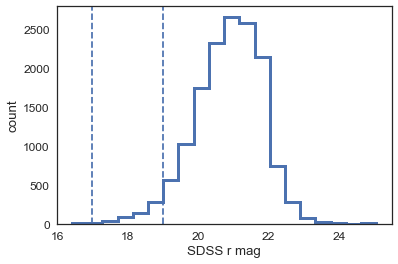

In [13]:
m_dec = np.abs(db_qso['DEC']) < 2
m_ra = np.abs(db_qso['RA_W']) < 50 
#for f in 'ugriz' : 
f = 'r'
m_mag = 15 < mag[f]
magmin, magmax = 17,19
plt.hist(mag[m_dec*m_ra*m_mag][f], histtype='step', bins=20, lw=3, label=f)
plt.axvline(magmin, ls='--')
plt.axvline(magmax, ls='--')
#plt.legend()
m_mag = (magmin< mag[f])*(mag[f]<magmax)
plt.xlabel('SDSS '+f+' mag')
plt.ylabel('count')

In [14]:
print('Of ', np.sum(m_ra*m_dec),' QSO within S82 footprint, ',
      np.sum(m_ra*m_dec*m_mag), ' are within' , magmin, '<',f,'<', magmax)

Of  14852  QSO within S82 footprint,  528  are within 17 < r < 19


In [9]:
# cross-match the catalogs : only select the RA range 
# that makes sense from DB12 , and take only the objects 
# that fulfil the magnitude cut ...

# this takes about 20 sec , so seems fine : 
# 
m_dec = np.abs(db_qso['DEC']) < 2
m_ra = np.abs(db_qso['RA_W']) < 50 
rmin, rmax = 17,20
m_r = (rmin < mag['r']) * (mag['r'] < rmax)
m_qso = m_dec * m_ra * m_r
print('Matching ', np.sum(m_qso), ' qso')

# I still limit the NSC catalog because 
# I want to get the cross matching time < 1 / H_0
# we don't expect dmag > 2 mag  between SDSS / NSC 
# if there were such discrepancy with a point source
# it's probably not too trustworthy...

m_mag = (rmin-2 < nsc['rmag'])*(nsc['rmag']<rmin+2)
m_dec = nsc['ra_W'] < 50
m_nsc = m_mag * m_dec
print('Against ', np.sum(m_nsc), ' NSC catalog sources...')

coords1 = SkyCoord(ra = db_qso['RA_W'][m_qso]*u.degree, 
                   dec=db_qso['DEC'][m_qso]*u.degree) 
coords2 = SkyCoord(ra = nsc['ra_W'][m_nsc]*u.degree, 
                   dec= nsc['dec'][m_nsc]*u.degree) 

# this is matching HLC to NSC, so that indices are into NSC catalog
# makes sense in this case since the NSC catalog is bigger than HLC here 
idx, d2d, d3d = coords1.match_to_catalog_sky(coords2)  
print('Done crossmatching')


Matching  2517  qso
Against  545137  NSC catalog sources...
Done crossmatching


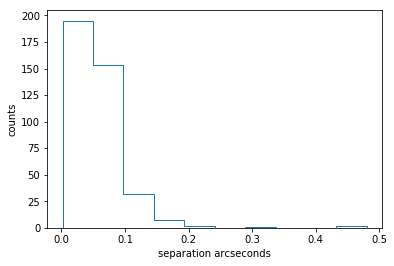

In [10]:
# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
qso = hstack([db_qso[m_qso], nsc[m_nsc][idx]], table_names = ['sdss', 'nsc'])
qso['sep_2d_arcsec'] = d2d.arcsec

%matplotlib inline
# plot the separation , select only good matches : 
x = qso['sep_2d_arcsec']
plt.hist( x[x<0.5],histtype='step')
plt.xlabel('separation arcseconds')
plt.ylabel('counts')

In [11]:
# Choose separation, and select only those object that have a nearest neighbor 
# from the NSC catalog within this radius ...
sep = 0.25
matched = qso['sep_2d_arcsec'] < sep
qsos =  qso[matched]
print('Of ', len(matched), ' QSO, we matched ', np.sum(matched), 'within ',sep,' arcsec')

Of  2517  QSO, we matched  389 within  0.25  arcsec


"plot the median and sigmaG vs. RA for RA and Dec proper motion components for quasars with 17 < r < 20 from that file (~1 deg wide bins in RA, but try a factor of 3 smaller and larger bins and discuss)"

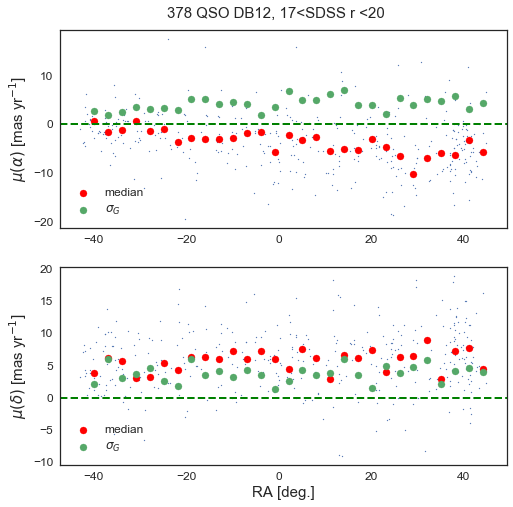

In [12]:
from scipy.stats import binned_statistic
from astroML import stats as astroMLstats
import seaborn as sns
sns.set(style='white', font_scale=1.2)

ra = qsos['ra_W']
dec = qsos['dec']
raPm = qsos['pmra']
decPm= qsos['pmdec']

bin_width = 3
bins = np.arange(min(ra), max(ra), bin_width)

fig,ax = plt.subplots(2,1,figsize=(8,8))

i = 0
for pm in [raPm, decPm] : 
    m = np.abs(pm) < 20 
    median = binned_statistic(ra[m], pm[m], statistic='median', bins=bins)
    sig = binned_statistic(ra[m], pm[m], statistic=astroMLstats.sigmaG, bins=bins)
    #im1 = ax[i].hexbin(ra[m], pm[m], bins='log', cmap=plt.cm.viridis,
    #           mincnt=1)
    ax[i].scatter(ra[m],pm[m], s=1, label='')
    ax[i].scatter(bins[1:], median.statistic, label='median', color='red')
    ax[i].scatter(bins[1:], sig.statistic, label=r'$\sigma_{G}$')
    ax[i].legend(fontsize=12, loc='lower left')
    ax[i].axhline(0,lw=2,ls='--', c='green')
    i += 1 

ax[0].set_ylabel(r'$\mu({\alpha})$'+' [mas yr'+''+r'$^{-1}$'+']', fontsize=15)
ax[1].set_ylabel(r'$\mu({\delta})$'+' [mas yr'+''+r'$^{-1}$'+']', fontsize=15)
ax[1].set_xlabel('RA [deg.]', fontsize=15)
fig.suptitle(str(len(ra[m]))+' QSO DB12, 17<SDSS r <20', y=0.92, fontsize=15)
plt.savefig('HW2_2c_QSO_SDSS_NSC.png', bbox_inches='tight')

Quasars are very far away, so if all local motion is taken into account, there shouldn't be any tangential motion. There could be some radial motion (Hubble flow), but that's not what we are plotting above. 